In [27]:
! pip install rdkit

^C



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
df = pd.read_csv('acetylcholinesterase_bioactivity_data_curated.csv')
df_no_smiles = df.drop(columns = 'canonical_smiles')

In [ ]:
smiles = []
for i in df.canonical_smiles.tolist():
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key = len)
    smiles.append(cpd_longest)
smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis = 1)
df_clean_smiles.to_csv('aetylcholinesterase_bioactivity_data_curated_cleaned.csv')

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

def lipinski(smiles, verbose = False):
    moldata = []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])
        
        if(i == 0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i+1

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)

    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_combined = pd.concat([df_clean_smiles, df_lipinski], axis = 1)
df_combined.to_csv('acetylcholinesterase_exploratory_lipinski.csv')

In [ ]:
df_combined.standard_value.describe()

count    6.157000e+03
mean     1.064665e+05
std      9.218081e+05
min      0.000000e+00
25%      1.480000e+02
50%      2.300000e+03
75%      1.700000e+04
max      4.960000e+07
Name: standard_value, dtype: float64

In [ ]:
-np.log10( (10**-9)* 100000000)

1.0

In [ ]:
-np.log10( (10**-9)* 10000000000)

-1.0

In [25]:
def norm_value(input):
    norm = []
    for i in input ['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis = 1)
    return x

In [26]:
df_norm = norm_value(df_combined)
df_norm

,Unnamed: 0.1,Unnamed: 0,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,0,0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,750.000
1,1,1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,100.000
2,2,2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,50000.000
3,3,3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,300.000
4,4,4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,800.000
...,...,...,...,...,...,...,...,...,...,...
6152,6152,8825,CHEMBL5219841,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,390.461,2.8334,2.0,5.0,0.209
6153,6153,8827,CHEMBL5219046,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,352.478,5.0610,1.0,3.0,274.000
6154,6154,8828,CHEMBL5219594,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,287.246,2.1994,1.0,4.0,76200.000
6155,6155,8829,CHEMBL5219958,inactive,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,311.337,3.1837,1.0,4.0,55000.000


In [29]:
df_norm.standard_value_norm.describe()

count    6.157000e+03
mean     1.064665e+05
std      9.218081e+05
min      0.000000e+00
25%      1.480000e+02
50%      2.300000e+03
75%      1.700000e+04
max      4.960000e+07
Name: standard_value_norm, dtype: float64

In [32]:
import numpy as np
def pIC50(input):
    pIC50 = []
    for i in input['standard_value_norm']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis = 1)
    return x

In [33]:
df_final = pIC50(df_norm)
df_final

C:\Users\msi\AppData\Local\Temp\ipykernel_17140\96452601.py:6: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))


,Unnamed: 0.1,Unnamed: 0,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,6.124939
1,1,1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,7.000000
2,2,2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,4.301030
3,3,3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,6.522879
4,4,4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...,...,...
6152,6152,8825,CHEMBL5219841,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,390.461,2.8334,2.0,5.0,9.679854
6153,6153,8827,CHEMBL5219046,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,352.478,5.0610,1.0,3.0,6.562249
6154,6154,8828,CHEMBL5219594,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,287.246,2.1994,1.0,4.0,4.118045
6155,6155,8829,CHEMBL5219958,inactive,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,311.337,3.1837,1.0,4.0,4.259637


In [34]:
df_final.pIC50.describe()

count    6157.000000
mean             inf
std              NaN
min         1.304518
25%         4.769551
50%         5.638272
75%         6.829738
max              inf
Name: pIC50, dtype: float64

In [35]:
df_final.to_csv('acetylcholinesterase_exploratory_pIC50.csv')

In [36]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,Unnamed: 0.1,Unnamed: 0,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.80320,0.0,6.0,6.124939
1,1,1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.55460,0.0,5.0,7.000000
2,2,2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.35740,0.0,5.0,4.301030
3,3,3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.70690,0.0,5.0,6.522879
4,4,4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...,...,...
6151,6151,8824,CHEMBL5219483,active,Cc1c(Cl)c(=O)oc2cc(OCCCCSC(=S)N3C(C)CCCC3C)ccc12,454.057,6.19482,0.0,5.0,6.943095
6152,6152,8825,CHEMBL5219841,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,390.461,2.83340,2.0,5.0,9.679854
6153,6153,8827,CHEMBL5219046,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,352.478,5.06100,1.0,3.0,6.562249
6154,6154,8828,CHEMBL5219594,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,287.246,2.19940,1.0,4.0,4.118045


In [37]:
df_2class.to_csv('acetylcholinesterase_exploratory_pIC50_2class.csv')

In [43]:
! pip install seaborn

  Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/294.6 kB ? eta -:--:--
     ----                                    30.7/294.6 kB 1.4 MB/s eta 0:00:01
     ----                                    30.7/294.6 kB 1.4 MB/s eta 0:00:01
     ----                                    30.7/294.6 kB 1.4 MB/s eta 0:00:01
     -----                                 41.0/294.6 kB 178.6 kB/s eta 0:00:02
     ---------                             71.7/294.6 kB 281.8 kB/s eta 0:00:01
     -----------                           92.2/294.6 kB 327.7 kB/s eta 0:00:01
     -----------                           92.2/294.6 kB 327.7 kB/s eta 0:00:01
     -------------                        112.6/294.6 kB 273.1 kB/s eta 0:00:01
     ---------------                      122.9/294.6 kB 288.8 kB/s eta 0:00:01
     ------------------                   153.6/294.6 kB 316.5 kB/s eta 0:00:01
     ------------------                   153.6/294.6 kB 316.5 kB/s eta 0:00:01
     ------------------                   153.6


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


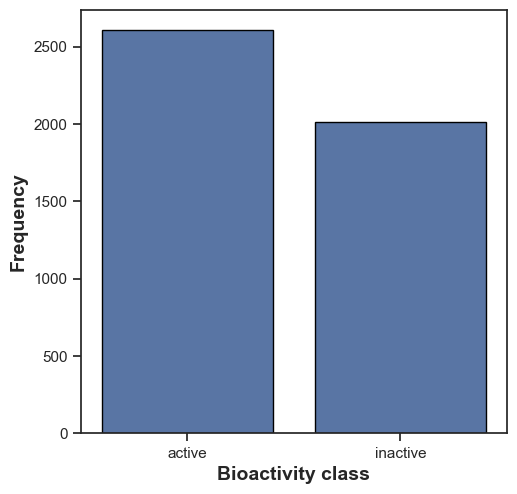

In [45]:
import seaborn as sns
sns.set(style = 'ticks')
import matplotlib.pyplot as plt

plt.figure(figsize = (5.5, 5.5))
sns.countplot (x = 'class', data = df_2class, edgecolor = 'black')
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
# plt.savefig('plot_bioactivity_class.pdf')

In [46]:
class_counts = df_2class['class'].value_counts()
class_counts

class
active      2608
inactive    2012
Name: count, dtype: int64

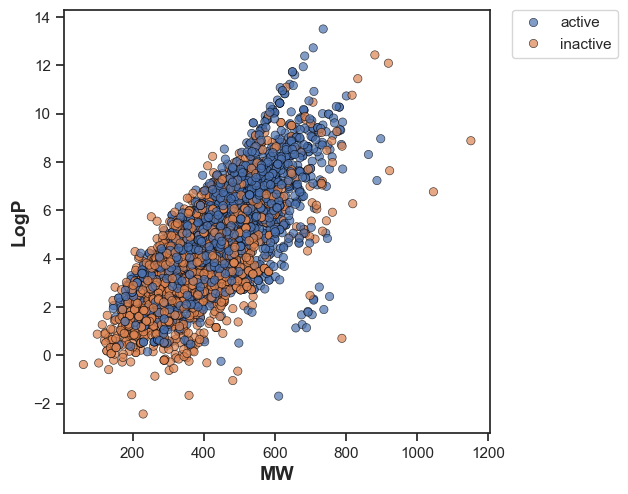

In [51]:
plt.figure(figsize = (5.5, 5.5))
sns.scatterplot(x = 'MW', y = 'LogP', data = df_2class, hue = 'class', edgecolor = 'black', alpha = 0.7)
plt.xlabel('MW', fontsize = 14, fontweight = 'bold')
plt.ylabel('LogP', fontsize = 14, fontweight = 'bold')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0)
# plt.savefig('plot_MV_vs_LogP.pdf')

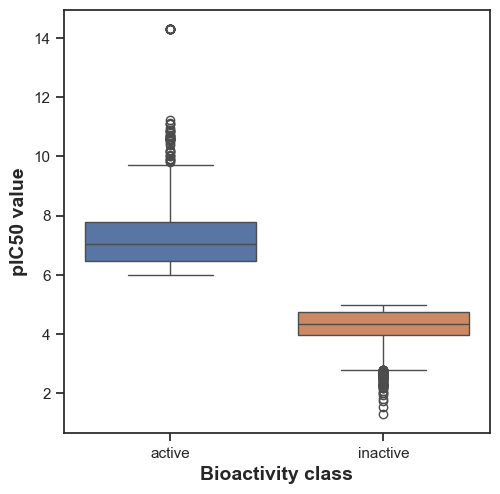

In [54]:
plt.figure(figsize = (5.5, 5.5))
sns.boxplot(x = 'class', y = 'pIC50', hue = 'class', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('pIC50 value', fontsize = 14, fontweight = 'bold')
# plt.savefig('plot_pIC50.pdf')

In [60]:
! pip install scipy

                                              0.0/44.1 MB ? eta -:--:--
                                             0.0/44.1 MB 991.0 kB/s eta 0:00:45
                                              0.1/44.1 MB 1.3 MB/s eta 0:00:34
                                              0.2/44.1 MB 1.5 MB/s eta 0:00:29
                                              0.3/44.1 MB 1.8 MB/s eta 0:00:25
                                              0.5/44.1 MB 2.4 MB/s eta 0:00:19
                                              0.8/44.1 MB 2.8 MB/s eta 0:00:16
                                              0.8/44.1 MB 2.8 MB/s eta 0:00:16
                                              0.8/44.1 MB 2.2 MB/s eta 0:00:20
                                              0.8/44.1 MB 2.0 MB/s eta 0:00:22
                                              0.8/44.1 MB 1.9 MB/s eta 0:00:24
                                              1.0/44.1 MB 2.0 MB/s eta 0:00:22
     -                                        1.1/44.1 MB 


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
def mannwhitney(descriptor, verbose = False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    seed(1)

    selection = [descriptor, 'class']
    df = df_2class[selection]
    active = df[df['class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'class']
    df = df_2class[selection]
    inactive = df[df['class'] == 'inactive']
    inactive = inactive[descriptor]

    stat, p = mannwhitneyu(active, inactive)

    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject HO)'
    else:
        interpretation = 'Different distribution (reject HO)'

    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index = [0])
    
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

In [74]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,5247296.0,0.0,0.05,Different distribution (reject HO)


In [75]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,3402939.0,2.507151e-67,0.05,Different distribution (reject HO)


In [76]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,3530973.5,1.340067e-90,0.05,Different distribution (reject HO)


In [77]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,3004079.0,6.682669e-19,0.05,Different distribution (reject HO)


In [78]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2826735.5,0.000005,0.05,Different distribution (reject HO)


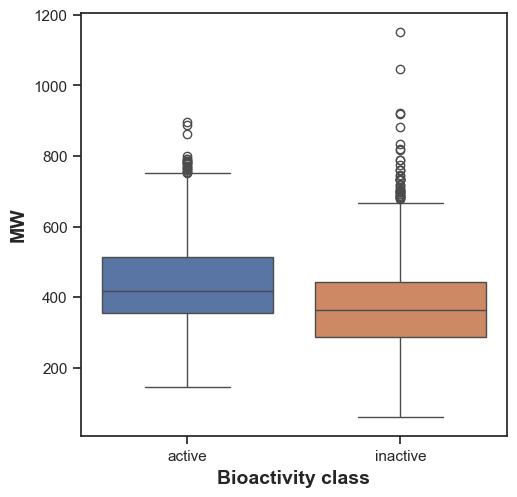

In [80]:
plt.figure(figsize = (5.5, 5.5))
sns.boxplot(x = 'class', y = 'MW', hue = 'class', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('MW', fontsize = 14, fontweight = 'bold')
# plt.savefig('plot_MW.pdf')

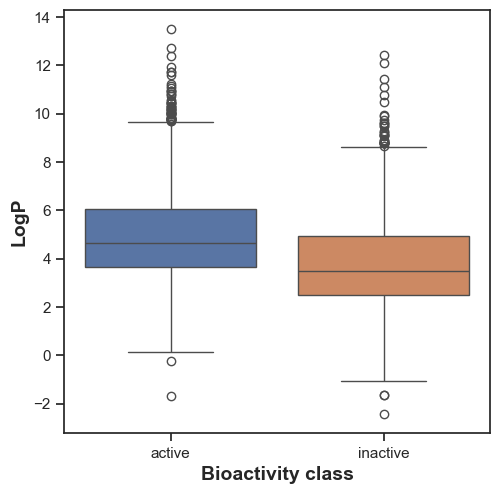

In [82]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'class', y = 'LogP', hue = 'class', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('LogP', fontsize = 14, fontweight = 'bold')
# plt.savefig('plot_LogP.pdf')

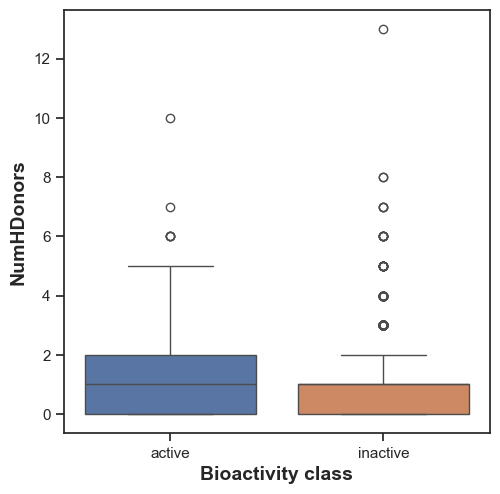

In [83]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'class', y = 'NumHDonors', hue = 'class', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHDonors', fontsize = 14, fontweight = 'bold')
# plt.savefig('plot_NumHDonors.pdf')

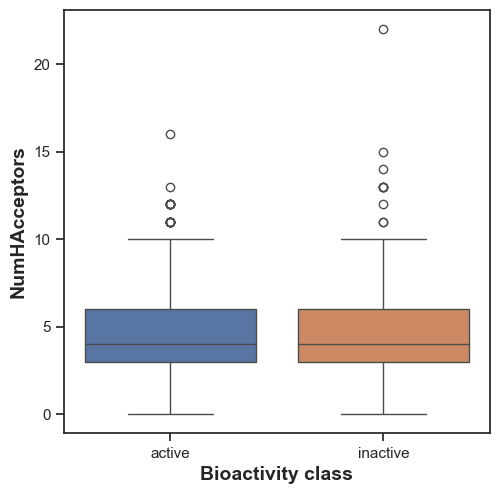

In [84]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'class', y = 'NumHAcceptors', hue = 'class', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHAcceptors', fontsize = 14, fontweight = 'bold')
# plt.savefig('plot_NumHAcceptors.pdf')